In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install -q --upgrade transformers==4.25.1 diffusers ftfy accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 53.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 81.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.0/261.0 kB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 35.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 106.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 88.3 MB/s eta 0:00:00


In [4]:
!pip install natsort

In [ ]:
import requests
import torch
import os
import numpy

from PIL import Image
from io import BytesIO
from base64 import b64encode
from pathlib import Path
from PIL import Image

from IPython.display import HTML
from matplotlib import pyplot as plt

from torch import autocast
from torchvision import transforms as tfms
from torchvision import datasets
from tqdm.auto import tqdm
from functools import partial
from typing import Callable, Optional

from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer
from diffusers.models import AutoencoderKL, UNet2DConditionModel
from diffusers import StableDiffusionPipeline
from diffusers.pipelines.stable_diffusion.safety_checker import \
    StableDiffusionSafetyChecker
from diffusers import DPMSolverMultistepScheduler
from torchvision import transforms
from diffusers.schedulers import DDIMScheduler, PNDMScheduler, LMSDiscreteScheduler


device = "cuda"
model_id_or_path = "runwayml/stable-diffusion-v1-5"

pipe = StableDiffusionPipeline.from_pretrained(model_id_or_path, torch_dtype=torch.float16)
pipe.enable_vae_tiling()
scheduler = DPMSolverMultistepScheduler.from_pretrained(model_id_or_path, subfolder='scheduler')
pipe.scheduler = scheduler

unet = UNet2DConditionModel.from_pretrained(model_id_or_path, subfolder="unet")
vae = AutoencoderKL.from_pretrained(model_id_or_path, subfolder="vae")

tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

pipe = pipe.to(device)
vae = vae.to(device)
text_encoder = text_encoder.to(device)
unet = unet.to(device);

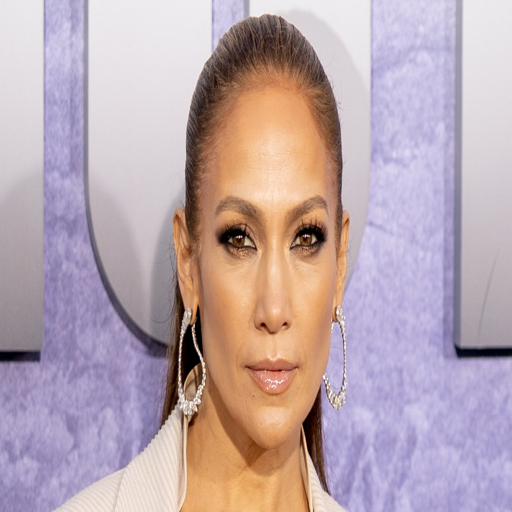

In [6]:
url = "https://media.allure.com/photos/646680ba8a75bca4ac12fbaf/16:9/w_1920,c_limit/jlo%202023.jpg"
response = requests.get(url)
init_image = Image.open(BytesIO(response.content)).convert("RGB")
init_image = init_image.resize((512, 512))
init_image

In [7]:
# Loading data
from torch.utils.data import Dataset
import natsort

data_dir_real = '/content/drive/MyDrive/data'
data_dir_fake = '/content/drive/MyDrive/100K_Faces_Images'
data_dir_fake_dif = '/content/drive/MyDrive/fake'
batch_size = 1

# Define datasets-
class CustomDataSet(Dataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.transform = transform
        all_imgs = os.listdir(main_dir)
        self.total_imgs = natsort.natsorted(all_imgs)

    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.total_imgs[idx])
        image = Image.open(img_loc).convert("RGB")
        tensor_image = self.transform(image)
        return tensor_image

my_dataset = CustomDataSet(data_dir_real, transforms.Compose([transforms.ToTensor(), transforms.Resize(512)]))
data_loader = torch.utils.data.DataLoader(my_dataset, batch_size=batch_size, shuffle=True,
                               num_workers=2, drop_last=True)

In [8]:
# Gradient methods
from scipy.signal import convolve2d
from scipy.linalg import hilbert
from numpy.random import randn, normal
from numpy.linalg import norm, inv
kernel_h = [[1, -1, 0]]
kernel_v = [[1], [-1], [0]]

def gradh(x):
    """Discrete gradient/difference in horizontal direction"""
    return convolve2d(x,kernel_h, mode='same', boundary='wrap')
def gradv(x):
    """Discrete gradient/difference in vertical direction"""
    return convolve2d(x,kernel_v, mode='same', boundary='wrap')
def grad2d(x):
    """The full gradient operator: compute both x and y differences and return them all.  The x and y
    differences are stacked so that rval[0] is a 2D array of x differences, and rval[1] is the y differences."""
    return numpy.stack([gradh(x),gradv(x)])


In [9]:
# Image mainpulation
def tensor_to_pil(img):
  img = (img / 2 + 0.5).clamp(0, 1)
  img = img.detach().cpu().permute(1, 2, 0).numpy()
  img = (img * 255).round().astype("uint8")
  pil = Image.fromarray(img)
  return pil

def tensor_to_tensor_grad1d(img, dim):
  img1 = img.to('cpu')
  img2 = torch.from_numpy(numpy.stack([grad2d(img1[0])[dim], grad2d(img1[1])[dim], grad2d(img1[2])[dim]]))
  return img2.to(img.device)

def pil_to_pil_grad1d(img, dim):
  img_t = transforms.Compose([transforms.ToTensor()])(img) * 2 - 1
  img_t = img_t.to('cpu')

  grad_t = torch.from_numpy(numpy.stack([grad2d(img_t[0])[dim], grad2d(img_t[1])[dim], grad2d(img_t[2])[dim]]))

  grad_t = (grad_t / 2 + 0.5).clamp(0, 1)
  grad_t = grad_t.detach().cpu().permute(1, 2, 0).numpy()
  grad_t = (grad_t * 255).round().astype("uint8")
  pil_grad = Image.fromarray(grad_t)
  return pil_grad

def tensor_to_latent(input_images):
  # Single image -> single latent in a batch (so size 1, 4, 64, 64)
  with torch.no_grad():
      latent = vae.encode((input_images).unsqueeze(0).to(device)*2-1) # Note scaling
  return 0.18215 * latent.latent_dist.sample()

def pil_to_latent(input_im):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    with torch.no_grad():
        latent = vae.encode((input_im).unsqueeze(0).to(device)*2-1) # Note scaling
    return 0.18215 * latent.latent_dist.sample()

def latents_to_pil(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

def latents_to_tensors(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    return image

def draw_images(lst_imgs):
  for img in lst_imgs:
    plt.imshow(img)
    plt.show()


In [10]:
# Implementing prompt embedding
def get_text_embedding(prompt):
  text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
  with torch.no_grad():
      text_embeddings = text_encoder(text_input.input_ids.to(device))[0]
  return text_embeddings

In [11]:
# Implementing Noise Scale Error and gradients of diffused pictures
from IPython.core import error

def reconstruct_latents_step_t(image_latents, text_embeddings, timestep,  noise):
  timestep_t = torch.LongTensor([timestep]).to(image_latents.device)
  noisy_latents = scheduler.add_noise(image_latents, noise, timesteps=timestep_t)

  with torch.no_grad():
    noise_pred = unet(noisy_latents, timestep_t, encoder_hidden_states=text_embeddings).sample

  alpha_t = scheduler.alphas_cumprod[timestep]
  reconstructed_latents = (noisy_latents - (1 - alpha_t) ** 0.5 * noise_pred) / (alpha_t ** 0.5)
  return reconstructed_latents

# Implementing adding two different types of noise
# Note: dataloader stores Tensors
def noise_scale_error(dataloader, text_embeddings, timestep1, timestep2):
  errors = []
  grad_x_0 = []
  grad_x_1 = []
  grad_x_2 = []
  grad_y_0 = []
  grad_y_1 = []
  grad_y_2 = []

  for step, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
      if step > 150:
        break # Testing!
      img = batch[0]
      img = img.to(device)

      image_latents = tensor_to_latent(img)
      #print(image_latents)
      noise = torch.randn(image_latents.shape).to(device)
      grad_x_0.append(tensor_to_tensor_grad1d(img, 0))
      grad_y_0.append(tensor_to_tensor_grad1d(img, 1))


      reconstructed_latents_1 = reconstruct_latents_step_t(image_latents, text_embeddings, timestep1, noise)
      reconstructed_latents_2 = reconstruct_latents_step_t(image_latents, text_embeddings, timestep2, noise)

      reconstructed_image1 = latents_to_tensors(reconstructed_latents_1)[0]
      grad_x_1.append(tensor_to_tensor_grad1d(reconstructed_image1, 0))
      grad_y_1.append(tensor_to_tensor_grad1d(reconstructed_image1, 1))

      reconstructed_image2 = latents_to_tensors(reconstructed_latents_2)[0]
      grad_x_2.append(tensor_to_tensor_grad1d(reconstructed_image2, 0))
      grad_y_2.append(tensor_to_tensor_grad1d(reconstructed_image2, 1))

      # draw_images(
      #   [tensor_to_pil(tensor_to_tensor_grad1d(img, 1)),
      #   pil_to_pil_grad1d(latents_to_pil(reconstructed_latents_1)[0], 1),
      #   pil_to_pil_grad1d(latents_to_pil(reconstructed_latents_2)[0], 1)]
      # )
      # draw_images(
      #   [latents_to_pil(image_latents)[0],
      #   latents_to_pil(reconstructed_latents_1)[0],
      #   latents_to_pil(reconstructed_latents_2)[0]]
      # )

      error1 = torch.norm(img - reconstructed_image1)
      error2 = torch.norm(img - reconstructed_image2)
      error = error1 / error2
      errors.append(error.item())

  return [grad_x_0, grad_x_1, grad_x_2], [grad_y_0, grad_y_1, grad_y_2]

In [12]:
# Alternative implemention of noisce scale error (using DDPM scheduler)
def add_noise_denoise(encoded, text_embeddings, start_step):
  # Add noise
  noise = torch.randn_like(encoded)
  latents = scheduler.add_noise(encoded, noise, timesteps=torch.tensor([scheduler.timesteps[start_step]]))
  latents = latents.to(device).float()

  # Denoise
  for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
    if i >= start_step: # << This is the only modification to the loop we do

        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = latents
        sigma = scheduler.sigmas[i]
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

        # perform guidance
        noise_pred_uncond = noise_pred
        noise_pred = noise_pred_uncond

        # compute the previous noisy sample x_t -> x_t-1
        latents = scheduler.step(noise_pred, t, latents).prev_sample

  return latents

def denoise_difference(encoded, text_embeddings, num_inference_steps : int, delta1 : int, delta2 : int):
  # Prep Scheduler (setting the number of inference steps)
  scheduler.set_timesteps(num_inference_steps)
  # Prep latents (noise appropriate for start_step)
  latent1 = add_noise_denoise(encoded, text_embeddings, delta1)

  #Repeat
  scheduler.set_timesteps(num_inference_steps)
  latent2 = add_noise_denoise(encoded, text_embeddings, delta2)
  return latent1, latent2

def noise_scale_error2(dataloader, text_embeddings, num_inference_steps, delta1, delta2):
  errors = []
  grad_x_0 = []
  grad_x_1 = []
  grad_x_2 = []
  grad_y_0 = []
  grad_y_1 = []
  grad_y_2 = []

  for step, batch in enumerate(dataloader):
      if step > 150:
        break # Testing!
      img = batch[0]
      img = img.to(device)

      image_latents = pil_to_latent(img)

      reconstructed_latents_1, reconstructed_latents_2 = denoise_difference(image_latents, text_embeddings, num_inference_steps, delta1, delta2)

      reconstructed_image1 = latents_to_tensors(reconstructed_latents_1)[0]
      reconstructed_image2 = latents_to_tensors(reconstructed_latents_2)[0]
      # plt.imshow(pil_to_pil_grad1d(latents_to_pil(image_latents)[0], 0))
      # plt.show()

      # plt.imshow(pil_to_pil_grad1d(latents_to_pil(reconstructed_latents_1)[0], 0))
      # plt.show()

      # plt.imshow(pil_to_pil_grad1d(latents_to_pil(reconstructed_latents_2)[0], 0))
      # plt.show()

      # draw_images(
      #     [latents_to_pil(image_latents)[0],
      #     latents_to_pil(reconstructed_latents_1)[0],
      #     latents_to_pil(reconstructed_latents_2)[0]]
      # )

      grad_x_0.append(tensor_to_tensor_grad1d(img, 0))
      grad_y_0.append(tensor_to_tensor_grad1d(img, 1))

      grad_x_1.append(tensor_to_tensor_grad1d(reconstructed_image1, 0))
      grad_y_1.append(tensor_to_tensor_grad1d(reconstructed_image1, 1))

      grad_x_2.append(tensor_to_tensor_grad1d(reconstructed_image2, 0))
      grad_y_2.append(tensor_to_tensor_grad1d(reconstructed_image2, 1))

      error1 = torch.norm(img - reconstructed_image1)
      error2 = torch.norm(img - reconstructed_image2)
      error = error1 / error2
      # print(step, error, error1, error2)
      errors.append([error.item(), error1, error2])

  return [grad_x_0, grad_x_1, grad_x_2], [grad_y_0, grad_y_1, grad_y_2]
  # return errors

In [ ]:
# Executing
prompt = ""
text_embeddings = get_text_embedding(prompt)

grad_x_m1, grad_y_m1 = noise_scale_error(data_loader, text_embeddings, 50, 150)
grad_x_m2, grad_y_m2 = noise_scale_error2(data_loader, text_embeddings, 100, 95, 85)
#print(grad_x)

In [ ]:
# Saving
torch.save(grad_x_m1, '/content/drive/MyDrive/gradients/m1_fake_x_500')
torch.save(grad_y_m1, '/content/drive/MyDrive/gradients/m1_fake_y_500')
torch.save(grad_x_m2, '/content/drive/MyDrive/gradients/m2_fake_x_500')
torch.save(grad_y_m2, '/content/drive/MyDrive/gradients/m2_fake_y_500')